In [1]:
import numpy as np
import pandas as pd
#import fma
import os
import pickle
import librosa
import scipy
import tensorflow as tf
from tqdm import tqdm
import multiprocessing
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

import keras
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input, Embedding, LSTM, GRU
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Bidirectional, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.utils import to_categorical
from torch.utils.data import Dataset, DataLoader


from sklearn.utils import shuffle
from sklearn.preprocessing import normalize


In [2]:
import IPython.display as ipd
import matplotlib.pyplot as plt

def display_waveform(waveform, title="", sr=8000):
    """Display waveform plot and audio play UI."""
    plt.figure()
    plt.title(title)
    plt.plot(waveform)
    ipd.display(ipd.Audio(waveform, rate=sr))

def stft3_quick(file_path):
    res = []
    Y, _ = librosa.load(file_path, sr=22050, res_type='kaiser_fast')
    for i in np.arange(0.0, 9.5, 0.5):
        y = Y[int(66150*i):min(len(Y),int(66150*(i+1)))]
        if y.shape[0] < 66150:
            y = np.pad(y, (0, 66150 - y.shape[0]), 'constant')
        res.append(np.abs(librosa.stft(y, n_fft=1024, window=scipy.signal.hanning, hop_length=512))[:,:128])
    res = np.array(res)
    return res, file_path

In [3]:
class MultispeakerDataset(Dataset):
    def __init__(self, index, path):
        self.path = path
        self.index = index
        self.all_files = [(i, name) for (i, speaker) in enumerate(index) for name in speaker]

    def __getitem__(self, index):
        speaker_id, name = self.all_files[index]
        speaker_onehot = (np.arange(len(self.index)) == speaker_id).astype(np.long)
        audio = np.load(f'{self.path}/{speaker_id}/{name}.npy')
        
        audio = (audio / np.abs(audio.max())).astype(np.float32)
        if audio.shape[0] < 66150:
            audio = np.tile(audio, int(np.ceil(66150/audio.shape[0])))
        audio = np.abs(librosa.stft(audio[0:66150], n_fft=1024, window=scipy.signal.hanning, hop_length=512))[:,:128]
        
        return speaker_onehot, audio

    def __len__(self):
        return len(self.all_files)

    def num_speakers(self):
        return len(self.index)


In [4]:
data_path = '/h/marko/vctk/WaveRnn-Multispeaker'
with open(f'{data_path}/index.pkl', 'rb') as f:
    index = pickle.load(f)

train_index = [[_ for o,_ in enumerate(x) if o % 10 != 0] for i, x in enumerate(index) if i < 16]
val_index = [x[::10] for i, x in enumerate(index) if i < 16]

dataset = MultispeakerDataset(train_index, data_path)
valset = MultispeakerDataset(val_index, data_path)

In [6]:
waveform = stft3_quick('000002.mp3')

/scratch/ssd001/home/marko/thesis/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [7]:
x = librosa.load('000002.mp3', sr=22050, res_type='kaiser_fast')

/scratch/ssd001/home/marko/thesis/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [8]:
X = x[0][int(66150*0):min(len(x[0]),int(66150*(1)))]
y = np.abs(librosa.stft(X, n_fft=1024, window=scipy.signal.hanning, hop_length=512))[:,:128]

In [9]:
y.shape

(513, 128)

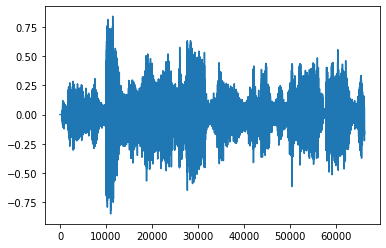

In [10]:
display_waveform(X, sr=22050)

### Evaluation

In [5]:
x_test = np.array([x[1] for x in valset])
y_test = np.array([x[0] for x in valset])
x_test = x_test.reshape(x_test.shape[0], 128, 513, 1)
np.save('x_test', x_test)
np.save('y_test', y_test)

In [7]:
model = load_model('curr_best_vctk.h5')

In [8]:
results = model.evaluate(x_test, y_test, batch_size=128)

10/10 [==============================] - 8s 442ms/step - loss: 2.4354 - accuracy: 0.2439


# Training Begins...

In [5]:
def define_model():
    # code taken and modified from 
    # https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
    model_name = 'best_rescnnqstft3_b128.h5'
    model = load_model(model_name)
    
    for layer in model.layers:
        layer.trainable = False  # mark loaded layers as not trainable
        
    # replace final layers
    flat1 = Flatten()(model.layers[-2].output)
    output = Dense(16, activation='softmax')(flat1)

    # define new model
    model = Model(inputs=model.inputs, outputs=output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
model = define_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 513, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 513, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 125, 1, 256)  525568      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 125, 1, 256)  262400      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
# x_train = np.array([x[1] for x in dataset])
# y_train = np.array([x[0] for x in dataset])
# x_train = x_train.reshape(x_train.shape[0], 128, 513, 1)
# np.save('x_train', x_train)
# np.save('y_train', y_train)

In [7]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

In [8]:
checkpoint = ModelCheckpoint('test_model', monitor='acc', verbose=2, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=2,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/20
84/84 - 55s - loss: 4.9748 - accuracy: 0.0767
Epoch 2/20
84/84 - 38s - loss: 4.0200 - accuracy: 0.1023
Epoch 3/20
84/84 - 38s - loss: 3.6744 - accuracy: 0.1172
Epoch 4/20
84/84 - 38s - loss: 3.3561 - accuracy: 0.1266
Epoch 5/20
84/84 - 38s - loss: 3.1525 - accuracy: 0.1408
Epoch 6/20
84/84 - 38s - loss: 3.0190 - accuracy: 0.1564
Epoch 7/20


KeyboardInterrupt: 

In [17]:
model.save('curr_best_vctk.h5')

In [18]:
model2 = load_model('curr_best_vctk.h5')
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 513, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 513, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 125, 1, 256)  525568      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 125, 1, 256)  262400      conv2d_1[0][0]                   
______________________________________________________________________________________________